There are 1 GPU(s) available.
Device name: GeForce GTX 1060 6GB
Let's use 1 GPUs
Validation:
Iteration: 9
Input image:


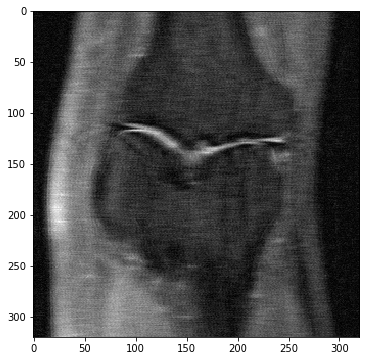

Perturbation Visualization:


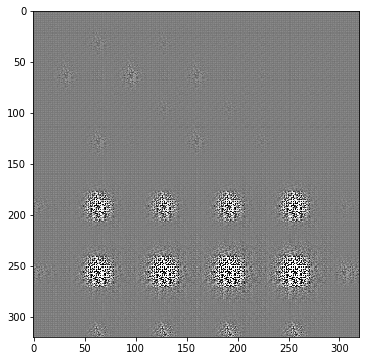

Original:


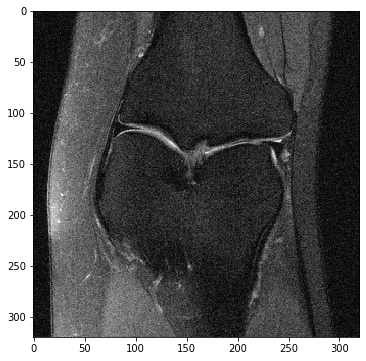

Original Image with Added Perturbation:


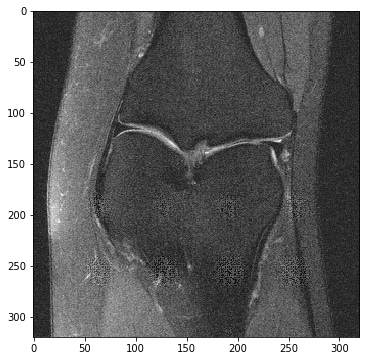

Reconstructed Without Perturbation(standard):


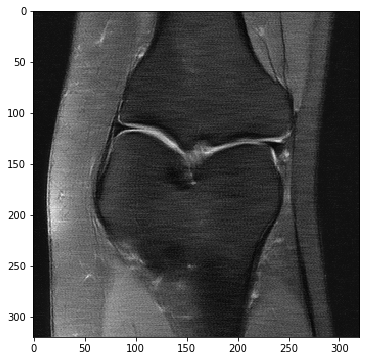

ssim: 0.39449499373503094
psnr: 23.708988597869958
Reconstructed With Perturbation(standard):


F:\FastMRI\fastMRI-master\my_models_3(eps=1e5\PerformanceMetrics.py:19: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  return compare_psnr(gt, pred, data_range=gt.max())


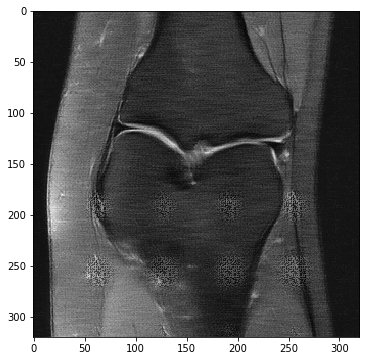

ssim: 0.3671986681553559
psnr: 22.77906307071046
Iteration: 73
Input image:


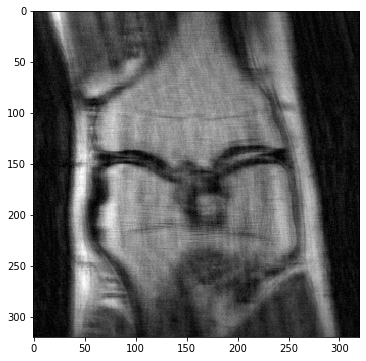

Perturbation Visualization:


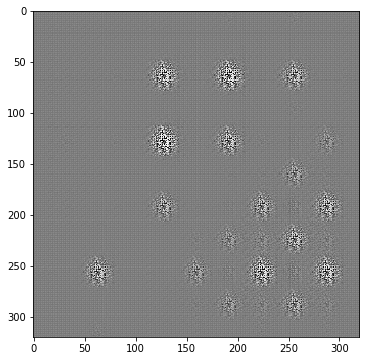

Original:


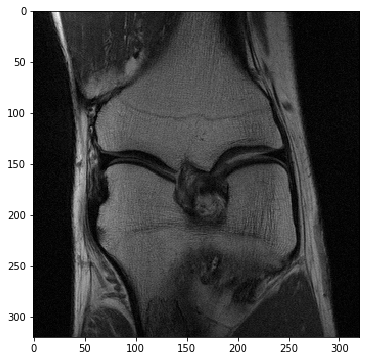

Original Image with Added Perturbation:


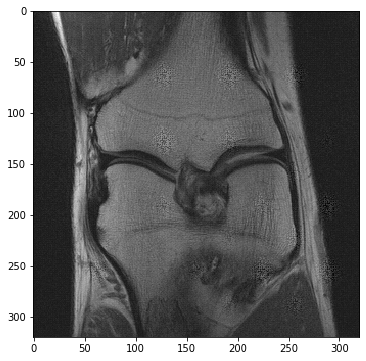

Reconstructed Without Perturbation(standard):


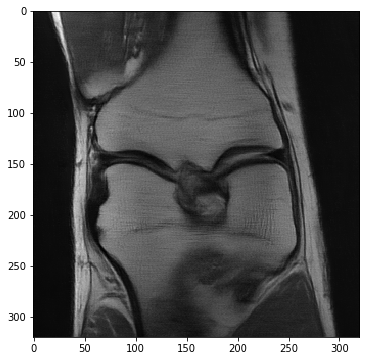

ssim: 0.6752630577492124
psnr: 28.676009689292048
Reconstructed With Perturbation(standard):


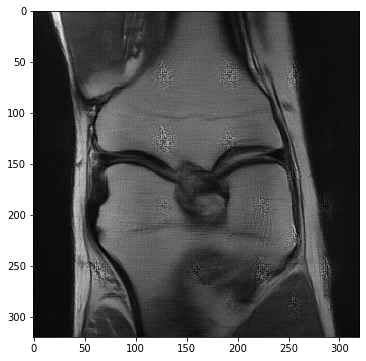

ssim: 0.6261297200292911
psnr: 27.040882196040307
Iteration: 137
Input image:


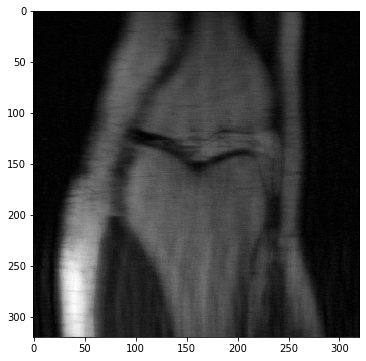

Perturbation Visualization:


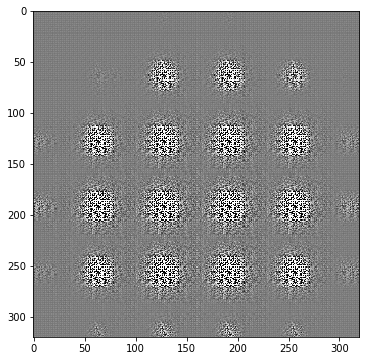

Original:


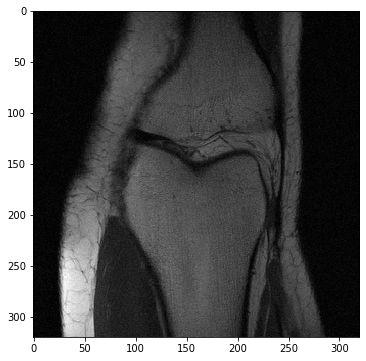

Original Image with Added Perturbation:


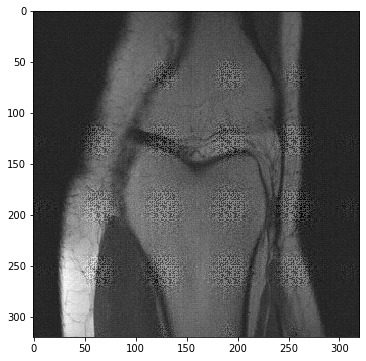

Reconstructed Without Perturbation(standard):


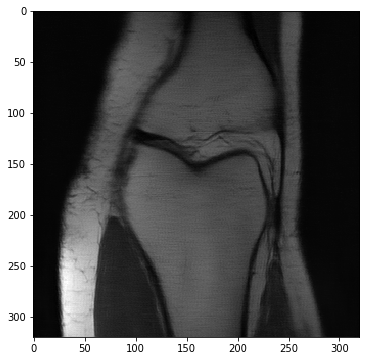

ssim: 0.7316634370792562
psnr: 31.152845316189357
Reconstructed With Perturbation(standard):


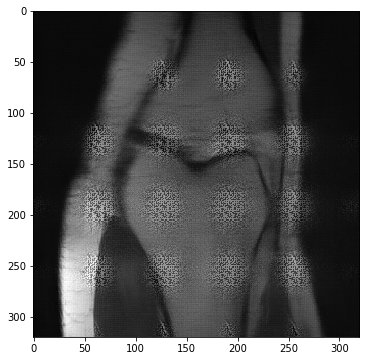

ssim: 0.5185890878444368
psnr: 22.521657308219112
Iteration: 553
Input image:


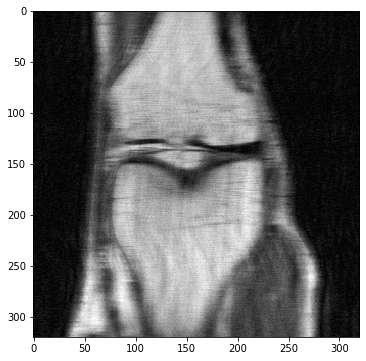

Perturbation Visualization:


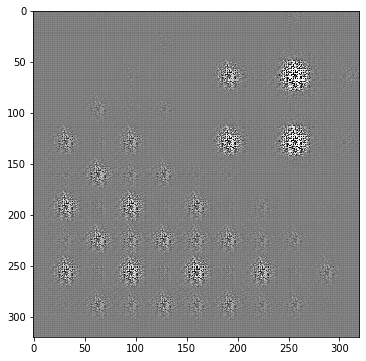

Original:


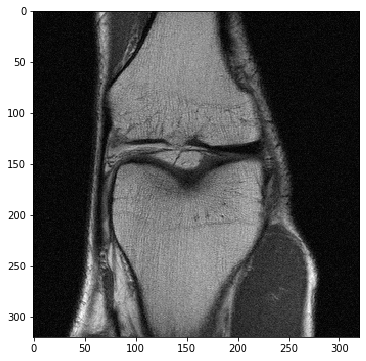

Original Image with Added Perturbation:


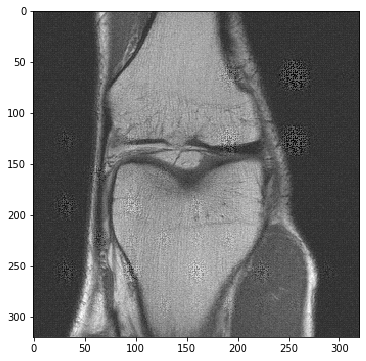

Reconstructed Without Perturbation(standard):


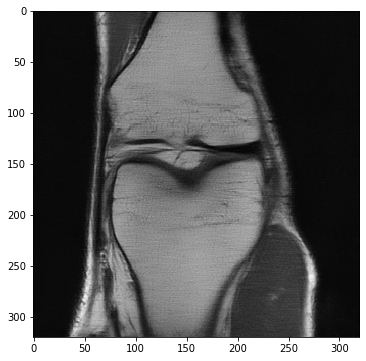

ssim: 0.5922002698516342
psnr: 26.075817441395746
Reconstructed With Perturbation(standard):


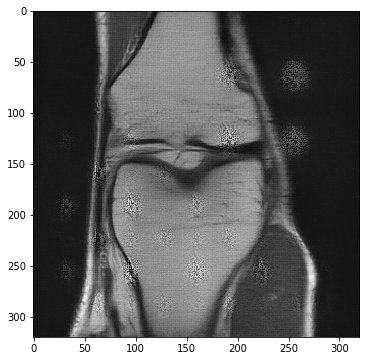

ssim: 0.5216653964139158
psnr: 23.21871611161505
Iteration: 569
Input image:


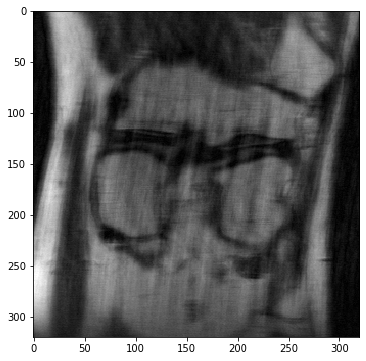

Perturbation Visualization:


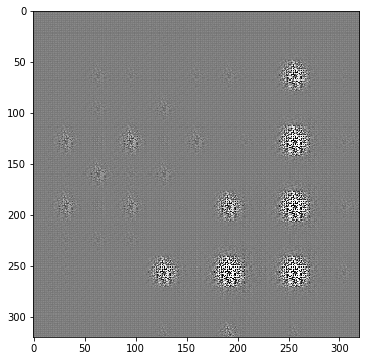

Original:


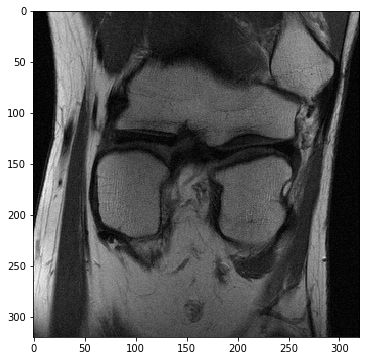

Original Image with Added Perturbation:


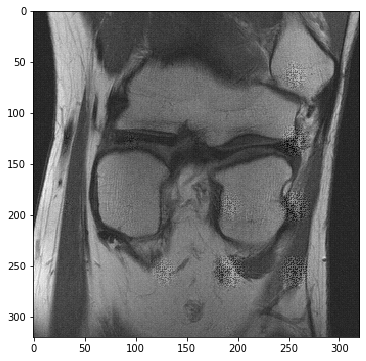

Reconstructed Without Perturbation(standard):


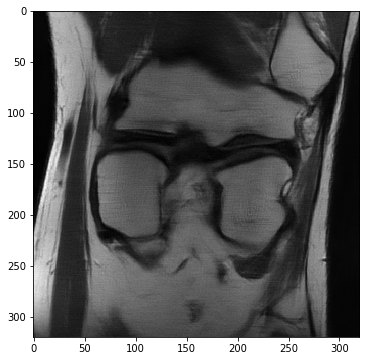

ssim: 0.6336584609843449
psnr: 26.387931942468754
Reconstructed With Perturbation(standard):


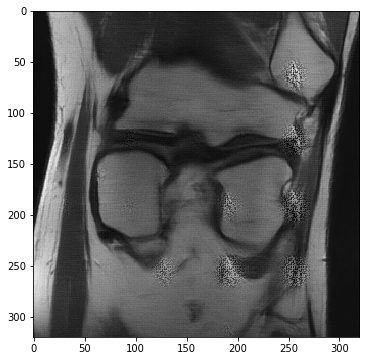

ssim: 0.5724682841060583
psnr: 23.907315417959794


In [1]:
# import progress bar libaray
from tqdm import trange, tqdm
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import UnetDataTransform
#from PerformanceMetrics import ssim, nmse, psnr
from FastMriDataModule import FastMriDataModule
from unet_model import Unet
from generator import Generator
from torch import nn
from matplotlib import pyplot as plt
import torch.distributed as dist
from PerformanceMetrics import ssim, psnr
from skimage.metrics import structural_similarity
from scipy.fft import fft
import torch
import pathlib

temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(999)
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# G
# load model
# Number of channels in the training images. For color images this is 3
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# create model, optimizer and criterion
# G
model_G = Generator(nc, nz, ngf)
    
# create model, optimizer and criterion
model_R1 = Unet(in_chans=1,
            out_chans=1,
            chans=64,
            num_pool_layers=5,
            drop_prob=0,
            )

model_R2 = Unet(in_chans=1,
            out_chans=1,
            chans=64,
            num_pool_layers=5,
            drop_prob=0,
            )

# use multiple GPUs
if torch.cuda.device_count() >= 1:
    print("Let's use", torch.cuda.device_count(), "GPUs")
    model_R1 = nn.DataParallel(model_R1)
    model_R2 = nn.DataParallel(model_R2)
    model_G = torch.nn.DataParallel(model_G)

# reconstructor
# from minmax
model_R1.to(device)
model_R1.load_state_dict(torch.load(r'unet_model_R.pt'))
model_R1.eval()

# standard model
model_R2.to(device)
model_R2.load_state_dict(torch.load(r'unet_model.pt'))
model_R2.eval()

# generator
model_G.to(device)
model_G.load_state_dict(torch.load(r'unet_model_G.pt'))
# set to eval mode
model_G.eval()

# this creates a k-space mask for transforming input data
mask = create_mask_for_mask_type('random', [0.08], [4])
# use random masks for train transform, fixed masks for val transform
train_transform = UnetDataTransform('singlecoil', mask_func=mask, use_seed=False)
val_transform = UnetDataTransform('singlecoil', mask_func=mask)
test_transform = UnetDataTransform('singlecoil')
# Initialize Process Group
dist.init_process_group('gloo', init_method='file:///tmp/somefile', rank=0, world_size=1)
# define the data loaders
batch_size = 1

data_module = FastMriDataModule(
    #data_path='/home/csci5980/liang664/train_demo',
    data_path='F:\FastMRI',
    challenge='singlecoil',
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=test_transform,
    test_split='test',
    test_path='F:\FastMRI\singlecoil_test',
    sample_rate=1,
    batch_size=batch_size,
    # may can use multiple workers here with linux?
    num_workers=0,
    distributed_sampler="ddp",
)

dataloader_tr = data_module.train_dataloader()
dataloader_val = data_module.val_dataloader()

# select slices
selected_slices = [9, 73, 137, 553, 569]
val_loss, nb_val_steps, ssim_val, tot_ssim, tot_psnr, tot_nmse = 0, 0, 0, 0, 0, 0
iteration = 0
print('Visualization:')
for sample in dataloader_val:
    iteration = iteration + 1
    data, target = sample[0].unsqueeze(1).to(device), sample[1].unsqueeze(1).to(device)
    output1 = model_R1(data)
#     output2 = model_R2(data)
    # perturbation
    latent_noise = torch.randn(1, nz, 1, 1, device=device) * 1e-3
    perturbation = model_G(latent_noise)
    #perturbation = torch.rand((1, 1, 320, 320)).to(device) * 0.5
    # outputs modification
    target_p = target + perturbation
    data_p = data + perturbation
    output_p1 = model_R1(data_p)
#     output_p2 = model_R2(data_p)
    # validation image
    save_dir = 'plt_save/'
    plt_data1 = output1.squeeze().detach().cpu().numpy()
    plt_data2 = output2.squeeze().detach().cpu().numpy()
    target = target.squeeze().detach().cpu().numpy()
    target_p = target_p.squeeze().detach().cpu().numpy()
    pert_plt_data1 = output_p1.squeeze().detach().cpu().numpy()
    pert_plt_data2 = output_p2.squeeze().detach().cpu().numpy()
    #print(plt_data[8].shape)
    if iteration in selected_slices:
        print(f"Iteration: {iteration}")
        print("Input image:")
        plt.figure(figsize = (6,6))
        plt.imshow(data.squeeze().cpu().detach().numpy(), cmap='gray')
        plt.show()
        print("Perturbation Visualization:")
        plt.figure(figsize = (6,6))
        plt.imshow(perturbation.squeeze().cpu().detach().numpy(), cmap='gray')
        plt.show()
        
        print("Original:")
        fig = plt.figure(figsize = (6,6))
        plt.imshow(target, cmap='gray')
        plt.show()
        
        print("Original Image with Added Perturbation:")
        fig = plt.figure(figsize = (6,6))
        plt.imshow(target_p, cmap='gray')
        plt.show()
        
        print("Reconstructed Without Perturbation(standard):")
        fig = plt.figure(figsize = (6,6))
        plt.imshow(plt_data1, cmap='gray')
        plt.show()
        print(f"ssim: {structural_similarity(target, plt_data1, multichannel=True, data_range=target.max())}")
        print(f"psnr: {psnr(target, plt_data1)}")
        
        print("Reconstructed Without Perturbation(standard):")
        fig = plt.figure(figsize = (6,6))
        plt.imshow(plt_data2, cmap='gray')
        plt.show()
        print(f"ssim: {structural_similarity(target, plt_data2, multichannel=True, data_range=target.max())}")
        print(f"psnr: {psnr(target, plt_data2)}")
        
        print("Reconstructed With Perturbation(standard):")
        fig = plt.figure(figsize = (6,6))
        plt.imshow(pert_plt_data1, cmap='gray')
        plt.show()
        print(f"ssim: {structural_similarity(target, pert_plt_data1, multichannel=True, data_range=target.max())}")
        print(f"psnr: {psnr(target, pert_plt_data1)}")
        
        print("Reconstructed With Perturbation(standard):")
        fig = plt.figure(figsize = (6,6))
        plt.imshow(pert_plt_data2, cmap='gray')
        plt.show()
        print(f"ssim: {structural_similarity(target, pert_plt_data2, multichannel=True, data_range=target.max())}")
        print(f"psnr: {psnr(target, pert_plt_data2)}")
        
        if iteration == selected_slices[len(selected_slices)-1]:
            break